# Experiment on Data Augmentation
In the previous notebook, you have done image classifications on the small **Dogs vs Cats** dataset. As we only used a small subset of the dataset containing 2,000 images for training, 1,000 for validation and 1,000 for testing, we observed significate overfitting problem.

Now, in this example, we will address the overfitting problem with **data augmentation**.


## Setting-Up 1: Mount Google Drive to the notebook
You can easily load data from Google Drive by mounting it to the notebook with the following code.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting-Up 2: One click to enable FREE GPU
Don't forget to enable GPU in your Colab notebook before training your model.

In Google Colab, it is very easy to do so.

From task bar, click: Runtime ⇨ Change runtime type

Choose 'GPU' in the Hardware accelerator.

## Dataset
Before you start this notebook, make sure the small dataset `dogs-vs-cats-small/`, which was generated in `dogs_vs_cats.ipynb`, is saved in your Google Drive. We will not repeat the "Downloading data ==> Creating small dataset" process in this notebook.

For efficient deep learning training in Google Colab, it is strongly recommended copying datasets from Google Drive to Colab’s local storage (`/content`) before training.
The benefit of using local directory is:
- Faster data access → Avoids slow I/O from Google Drive API.
- Better GPU performance → Reduces bottlenecks in loading images/batches.
- More stable training → Prevents disconnections from Google Drive.
You may use first copy datasets to the local directory with command `rsync`(recommended) or `cp`(slower):

`!rsync -avh "/content/drive/MyDrive/dataset/" "/content/dataset/"`

Please note: The `/content` directory is temporary and will be deleted when the session resets.

In [3]:
import os
import shutil

# Colab's local storage to store the dataset for faster training
local_dataset_dir = "/content/dogs-vs-cats-small"
if not os.path.exists(local_dataset_dir): # always check if the directory exists
  # Copy the dataset (preserves all subfolders and files)
  print("Copy dataset to Colab's local storage...")
  !rsync -avh "/content/drive/MyDrive/Colab Notebooks/data/dogs-vs-cats-small/" "/content/dogs-vs-cats-small/"
  print("Copy done.")

train_dir = os.path.join(local_dataset_dir,'train')
val_dir   = os.path.join(local_dataset_dir,'val')
test_dir  = os.path.join(local_dataset_dir,'test')
if not os.path.exists(train_dir):
  print(train_dir +' does not exist.')
if not os.path.exists(val_dir):
  print(val_dir +' does not exist.')
if not os.path.exists(test_dir):
  print(test_dir +' does not exist.')

n_train_per_class = 1000
n_val_per_class = 500
n_test_per_class = 500

Copy dataset to Colab's local storage...
sending incremental file list
created directory /content/dogs-vs-cats-small
./
test/
test/cats/
test/cats/cat.1500.jpg
test/cats/cat.1501.jpg
test/cats/cat.1502.jpg
test/cats/cat.1503.jpg
test/cats/cat.1504.jpg
test/cats/cat.1505.jpg
test/cats/cat.1506.jpg
test/cats/cat.1507.jpg
test/cats/cat.1508.jpg
test/cats/cat.1509.jpg
test/cats/cat.1510.jpg
test/cats/cat.1511.jpg
test/cats/cat.1512.jpg
test/cats/cat.1513.jpg
test/cats/cat.1514.jpg
test/cats/cat.1515.jpg
test/cats/cat.1516.jpg
test/cats/cat.1517.jpg
test/cats/cat.1518.jpg
test/cats/cat.1519.jpg
test/cats/cat.1520.jpg
test/cats/cat.1521.jpg
test/cats/cat.1522.jpg
test/cats/cat.1523.jpg
test/cats/cat.1524.jpg
test/cats/cat.1525.jpg
test/cats/cat.1526.jpg
test/cats/cat.1527.jpg
test/cats/cat.1528.jpg
test/cats/cat.1529.jpg
test/cats/cat.1530.jpg
test/cats/cat.1531.jpg
test/cats/cat.1532.jpg
test/cats/cat.1533.jpg
test/cats/cat.1534.jpg
test/cats/cat.1535.jpg
test/cats/cat.1536.jpg
test/cats/ca

## STEP 1: Data preprocessing
Now we need do some pre-processing before feeding the data into the network.

Roughly, the preprocessing consists of following steps.
1. Read the image files, decode them to RGB grids of pixels
2. Rescale the pixel values (integers between 0 and 255) to the [0,1] interval, to enhance training stability of neural networks.
3. Apply data augmentation.

There are two ways to apply augmentation to training images using the random transforms of `layers`.

Option 1: Make the preprocessing layers part of your model. It directly add the augmentation layer into the model structure as the first layer.

Option 2: Apply the preprocessing layers to your dataset. It is to apply the data augmentation to the entire train set using `Dataset.map`.

I implement Option 1 as follows. You may reference the follow link for Option 2: https://www.tensorflow.org/tutorials/images/data_augmentation

Note: In either option, no data augmentation is applied for either test or validation samples.

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


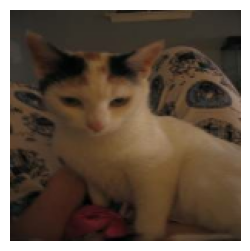

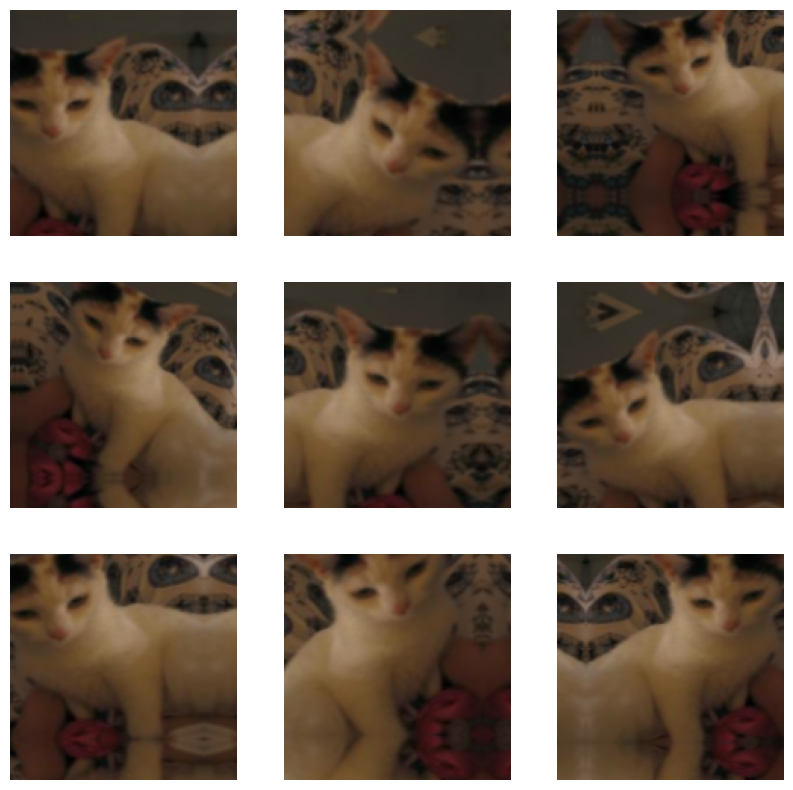

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

# Define batch size and image size
batch_size = 32
img_size = (150, 150)

# Load the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)

# Load the validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

# Normalize images (rescale pixel values to [0,1])
normalization_layer = layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

#Apply Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),  # Flip left-right
    layers.RandomRotation(0.1),  # Rotate by 10%, i.e., ±36°
    layers.RandomZoom(0.2),  # Zoom in/out ±20%
    layers.RandomTranslation(0.2, 0.2),  # Shift in height/width ±20%
    #layers.RandomShear(0.1)  # Shear transformation ±10%
])


# Display some randomly augmented training images.
be_show_augment = True
if be_show_augment:
  import matplotlib.pyplot as plt
  for images, labels in train_dataset.take(1):  # Take one batch
      plt.figure(figsize=(3, 3))
      img = images[3]  # Extract a single image
      plt.imshow(img)
      plt.axis("off")
      plt.show()

      plt.figure(figsize=(10, 10))
      img = tf.expand_dims(img, axis=0)  # Add batch dimension (1, 150, 150, 3)
      for i in range(9):  # Show 9 images
          augmented_image = data_augmentation(img, training=True)  # Apply augmentation

          plt.subplot(3, 3, i + 1)
          plt.imshow(tf.squeeze(augmented_image))  # Remove batch dim for visualization

          plt.axis("off")
      plt.show()

# Additional Performance Optimization (Optional)
# Benefit of using AUTOTUNE:
# 1. Loads the next batch while the current batch is being processed
# 2. Reduces data loading bottlenecks
# 3. Improves training speed
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)


## STEP 1: Build the CNN network
Use the same small convnet in `dogs_vs_cats.ipynb`. **Don't add any other regularization** techniques (such as dropout), as you will know any performance changes in this experiment is purely because of data augmentation.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

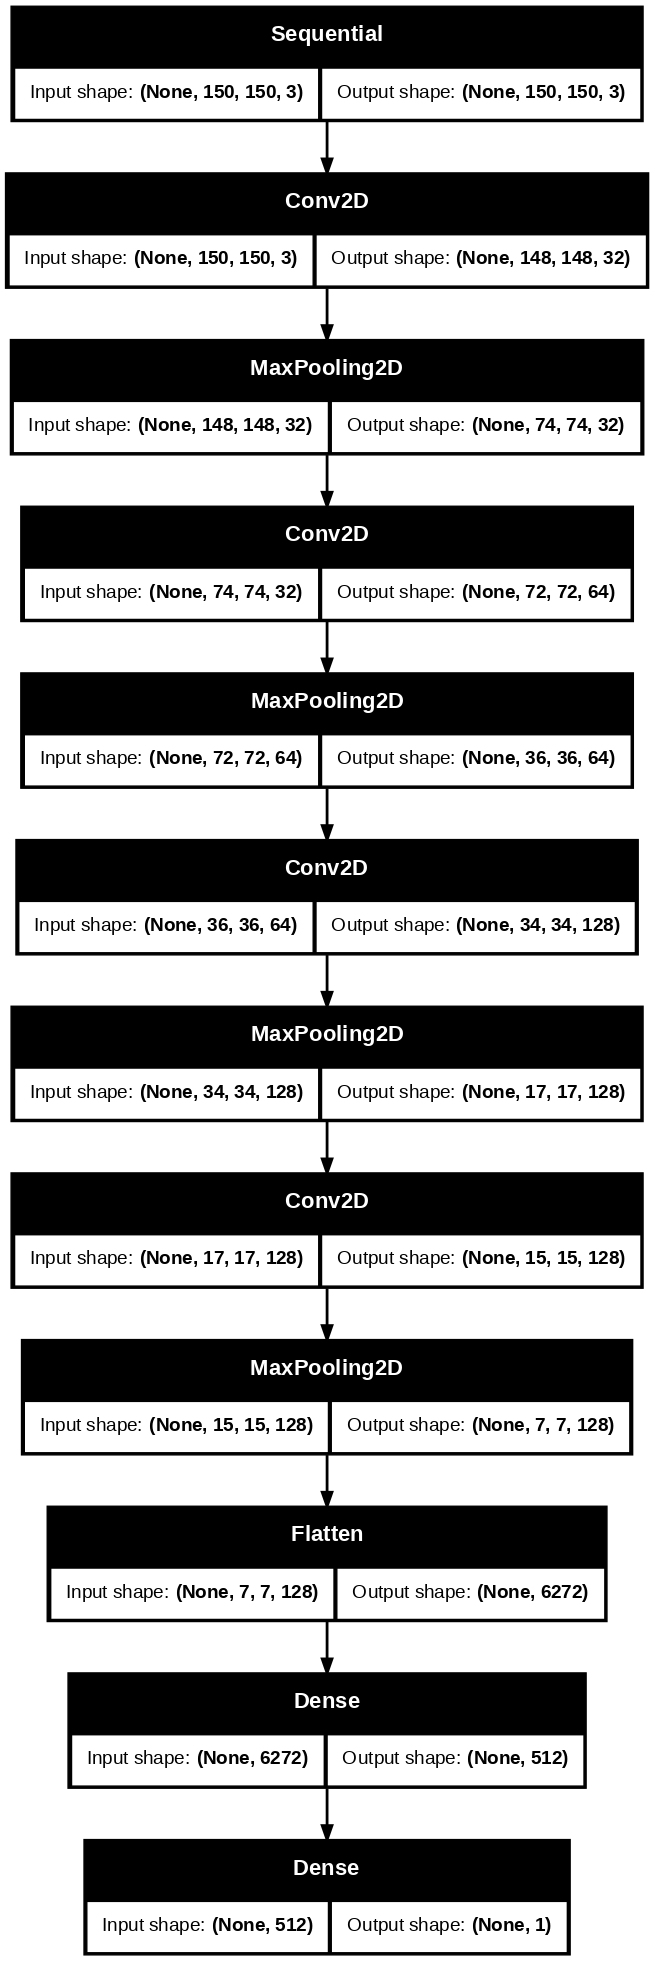

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential([
  Input(shape=(150, 150, 3)),
  data_augmentation,
  Conv2D(32, (3, 3), activation='relu'),
  MaxPooling2D((2, 2)),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D((2, 2)),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D((2, 2)),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D((2, 2)),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(1, activation='sigmoid')
])
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, dpi=100) # visualize the CNN artitecture

## STEP 2: Compile the model
The typical loss function for a binary classification problem is the binary cross-entropy loss function.

In [6]:
model.compile(loss='binary_crossentropy',
            optimizer='adam',#adam (with default parameters) is always a good choice
            metrics=['accuracy'])

## STEP 4: Train the model and draw learning curves
Let's train the model. You may need more epochs in this training, say `epochs=120`.

It is a good practice to always save your models after training with `model.save_model(model_folder+'/dogs_cats_small_data_augment.keras') `.

After training, also plot the loss and accuracy of the model over the training and validation set.

Epoch 1/120
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.4908 - loss: 0.7389 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/120
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5134 - loss: 0.6931 - val_accuracy: 0.5160 - val_loss: 0.6917
Epoch 3/120
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5235 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.8327
Epoch 4/120
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.5174 - loss: 0.6991 - val_accuracy: 0.5230 - val_loss: 0.7032
Epoch 5/120
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5542 - loss: 0.6932 - val_accuracy: 0.5050 - val_loss: 0.6858
Epoch 6/120
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5534 - loss: 0.6888 - val_accuracy: 0.5610 - val_loss: 0.6855
Epoch 7/120
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5543 - loss: 0.6862 - val_accuracy: 0.6070 - val_loss: 0.6689
Epoch 8/120
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5779 - loss: 0.6766 - val_accuracy: 0.

Text(0.5, 0, 'epoch')

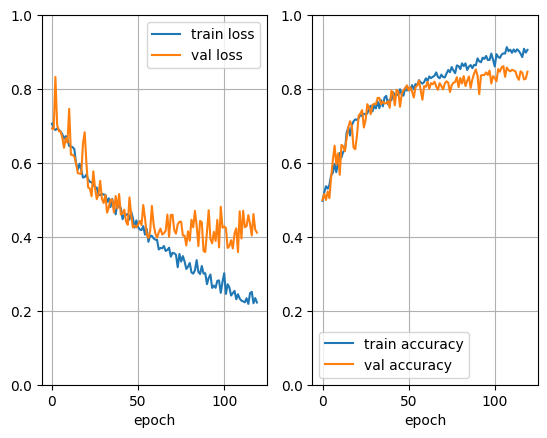

In [7]:

# Train the model
epochs = 120
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

model_folder = '/content/drive/MyDrive/Colab Notebooks/models'
import os
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
model.save(model_folder+'/dogs_cats_small_data_augment.keras')  # always save your weights after training

# plot the learning curves
import matplotlib.pyplot as plt
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

fig.add_subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

In [8]:
val_loss, val_acc = model.evaluate(val_dataset)
print(f"validation Accuracy: {val_acc:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8536 - loss: 0.4094
validation Accuracy: 0.8470


**Results** If everything goes well, you must see the learning curves are not as smooth as those without data augmentation. It is because that augmentation introduces more diverse training samples, which can create more noise in the learning process. There still exists overfitting problem, however, it is not as severe as in the previous experiment (without data augmentation). Thanks to data augmentation, the accuracy on the validation set reaches around 85%, 10%-13% relative improvement over the non-data-augmentation model.

Now, you may be able to get an even better accuracy if you tuning the network's parameters, or add some other regularization techniques, such as drop out, early stopping, weight regularization, batch normalization.

